# **Dacon 퇴근시간 버스 승차인원 예측**
[ 20.7.30 ~ 20.8.19 ]

## < Feature Engineering >
1. LabelEncoding
2. Groupby
3. Date info
4. Weather info
5. Lat, long distance
6. Bts bus
7. K-means + groupby
8. PCA
9. Airport info 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os, random, time, gc, warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from datetime import datetime

import folium
from folium import Marker, Icon, CircleMarker

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/test.csv')
df_bus = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/bus_bts.csv')
bus_interval = pd.read_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/bus_interval_final.csv")

In [5]:
# 배차간격 정보 합치기(따로 만듦)
train['is_test'] = 0
test['is_test'] = 1
data = pd.concat([train, test])
data['bus_route_id'] = data['bus_route_id'].astype(np.int64)
data = pd.merge(data, bus_interval, how = 'left', on = 'bus_route_id')
data['bus_interval'] = data['bus_interval'].fillna(9999)

In [6]:
train = data.query('is_test==0')
test = data.query('is_test==1')

## 1. 라벨인코딩

In [7]:
# 라벨 인코딩
target_col = '18~20_ride'
train_label = train[target_col]

lbl = LabelEncoder()

# Implement Label Encoding 
cat_cols = ['bus_route_id','in_out','station_code','station_name']
for col in tqdm_notebook( cat_cols ):
    
    # Label-Encoding을 fitting함
    lbl.fit( train[[col]].append(test[[col]]) )
    
    # train/test label_encoding한 값을 대입함
    train[col] = lbl.transform(train[col])
    test[col] = lbl.transform(test[col])

## 2. 승하차 groupby 관련

In [8]:
# 승하차 간격을 2시간 간격으로 설정(예측해야 하는 18~20ride가 두시간이기 때문에)
dawn_ride_cols, dawn_takoff_cols = ['6~7_ride','7~8_ride'], ['6~7_takeoff','7~8_takeoff']
morning_ride_cols, morning_takeoff_cols = ['8~9_ride','9~10_ride'], ['8~9_takeoff','9~10_takeoff']
noon_ride_cols, noon_takeoff_cols = ['10~11_ride','11~12_ride'], ['10~11_takeoff','11~12_takeoff']

# 새벽, 오전, 점심 승차량 함수
def f(df):
    # ride columns
    df['dawn_ride'] = df[dawn_ride_cols].sum(axis=1)
    df['morning_ride'] = df[morning_ride_cols].sum(axis=1)
    df['noon_ride'] = df[noon_ride_cols].sum(axis=1)
    
    # takeoff columns
    df['dawn_takeoff'] = df[dawn_takoff_cols].sum(axis=1)
    df['morning_takeoff'] = df[morning_takeoff_cols].sum(axis=1)
    df['noon_takeoff'] = df[noon_takeoff_cols].sum(axis=1)
    
    # drop columns
    drop_cols = dawn_ride_cols + morning_ride_cols + noon_ride_cols + dawn_takoff_cols + morning_takeoff_cols + noon_takeoff_cols
    df = df.drop(drop_cols, 1)
    return df

train = f(train)
test = f(test)

In [9]:
## Groupby : mean, sum
# (1) bus_route_id 기준
# 탑승
train['avg_dawn_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
train['avg_morning_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
train['avg_noon_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['noon_ride'].transform('mean') 

test['avg_dawn_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
test['avg_morning_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
test['avg_noon_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['noon_ride'].transform('mean') 

# 하차
train['avg_dawn_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
train['avg_morning_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
train['avg_noon_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean') 

test['avg_dawn_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
test['avg_morning_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
test['avg_noon_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean') 

# (2) bus_route_id, station_code 기준
train['avg_dawn_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('mean') 
train['avg_morning_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('mean') 
train['avg_noon_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('mean') 

test['avg_dawn_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('mean') 
test['avg_morning_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('mean') 
test['avg_noon_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('mean') 

# (3) station_code 기준
train['avg_dawn_ride_station_code'] = train.groupby(['date','station_code'])['dawn_ride'].transform('mean') 
train['avg_morning_ride_bus_station_code'] = train.groupby(['date','station_code'])['morning_ride'].transform('mean') 
train['avg_noon_ride_station_code'] = train.groupby(['date','station_code'])['noon_ride'].transform('mean') 

test['avg_dawn_ride_station_code'] = test.groupby(['date','station_code'])['dawn_ride'].transform('mean') 
test['avg_morning_ride_bus_station_code'] = test.groupby(['date','station_code'])['morning_ride'].transform('mean') 
test['avg_noon_ride_station_code'] = test.groupby(['date','station_code'])['noon_ride'].transform('mean') 

#################################################################################################################
# (1) bus_route_id 기준
train['sum_dawn_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_ride'].transform('sum') 
train['sum_morning_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['morning_ride'].transform('sum') 
train['sum_noon_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['noon_ride'].transform('sum') 

test['sum_dawn_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['dawn_ride'].transform('sum') 
test['sum_morning_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['morning_ride'].transform('sum') 
test['sum_noon_ride_bus_route_id'] = test.groupby(['date','bus_route_id'])['noon_ride'].transform('sum') 

train['sum_dawn_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('sum') 
train['sum_morning_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['morning_takeoff'].transform('sum') 
train['sum_noon_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['noon_takeoff'].transform('sum') 

test['sum_dawn_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('sum') 
test['sum_morning_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['morning_takeoff'].transform('sum') 
test['sum_noon_takeoff_bus_route_id'] = test.groupby(['date','bus_route_id'])['noon_takeoff'].transform('sum') 

# (2) bus_route_id, station_code 기준
train['sum_dawn_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('sum') 
train['sum_morning_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('sum') 
train['sum_noon_ride_bus_route_id_station_code'] = train.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('sum') 

test['sum_dawn_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['dawn_ride'].transform('sum') 
test['sum_morning_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['morning_ride'].transform('sum') 
test['sum_noon_ride_bus_route_id_station_code'] = test.groupby(['date','bus_route_id','station_code'])['noon_ride'].transform('sum') 

# (3) station_code 기준
train['sum_dawn_ride_station_code'] = train.groupby(['date','station_code'])['dawn_ride'].transform('sum') 
train['sum_morning_ride_bus_station_code'] = train.groupby(['date','station_code'])['morning_ride'].transform('sum') 
train['sum_noon_ride_station_code'] = train.groupby(['date','station_code'])['noon_ride'].transform('sum') 

test['sum_dawn_ride_station_code'] = test.groupby(['date','station_code'])['dawn_ride'].transform('sum') 
test['sum_morning_ride_bus_station_code'] = test.groupby(['date','station_code'])['morning_ride'].transform('sum') 
test['sum_noon_ride_station_code'] = test.groupby(['date','station_code'])['noon_ride'].transform('sum') 


## 3. 날짜 관련

In [10]:
# 요일 정보 추가
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date']) 
train['weekday'] = train['date'].dt.weekday
test['weekday']  = test['date'].dt.weekday

# 공휴일 정보 추가(추석, 개천절, 한글날)
holidays = [datetime(2019, 9 ,12), datetime(2019, 9, 13), datetime(2019, 9 ,14), datetime(2019, 10,3), datetime(2019, 10,9) ]
train['is_holiday'] = train['date'].apply(lambda x: x in holidays).astype(np.int8)
test['is_holiday']  = test['date'].apply(lambda x: x in holidays).astype(np.int8)

## 4. 날씨 관련
9~10월 사이에 제주도에 태풍이 옴. 이를 반영하는게 중요할 것이라고 생각. 

In [11]:
## 날씨 정보(강수량)
df_weather = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/weather.csv', encoding='cp949')
df_weather = df_weather[['일시','강수량(mm)']]
df_weather.columns = ['date','precipitation']
df_weather['date'] = pd.to_datetime( df_weather['date'] )

# 리키지방지
df_weather = df_weather[(df_weather['date']>='2019-08-31 00:00:00')&(df_weather['date']<='2019-10-16 23:00:00')].reset_index(drop=True)
df_weather['hour'] = df_weather['date'].dt.hour
df_weather['date'] = df_weather['date'].dt.date

# 전날의 강수량을 정보
df_prevday_weather = df_weather.groupby('date')['precipitation'].sum().reset_index()
df_prevday_weather.columns = ['prev_date', 'prevday_precipitation']

# 해당 날짜의 강수량을 구함(17시 이전까지의 당일 날씨정보만 활용)
df_weather = df_weather[df_weather['hour']<=17].reset_index(drop=True)

df_weather = df_weather.groupby('date')['precipitation'].sum().reset_index()
df_prevday_weather['prev_date'] = pd.to_datetime( df_prevday_weather['prev_date']  )
df_weather['date'] = pd.to_datetime( df_weather['date']  )

In [12]:
# prev_date : 전날
train['prev_date'] = train['date'] - pd.Timedelta('1 day')
test['prev_date'] = test['date'] - pd.Timedelta('1 day')

train = pd.merge(train, df_prevday_weather , on ='prev_date',  how ='left')
test = pd.merge(test, df_prevday_weather , on ='prev_date',how ='left')

train = train.drop('prev_date',1)
test = test.drop('prev_date',1)

train = pd.merge( train, df_weather , on ='date', how='left')
test = pd.merge( test, df_weather , on ='date', how='left')

## 5. 위치정보
- 정류장의 위도/경도가 중요했음. 
- geopy.distance.vincenty 활용
- pca 로 피쳐생성

In [13]:
%%time
# 좌표 사이 거리 추가
import geopy.distance
from collections import Counter
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name']) # Counter를 통해 확인
# 0 : 제주/ 1 : 고산/ 2 : 성산/ 3 : 포

# test
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
# test = pd.get_dummies(test, columns=['dist_name'])

# 좌표 데이터 변수 추가
coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
train['dis_jejusi'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]

coords_jejusicheong1 = (33.49892, 126.53035) #제주시청(광양방면)의 위도 경도
coords_jejuairport = (33.50661, 126.49345) #제주국제공항(구제주방면)의 위도 경도
coords_hallahosp = (33.48963, 126.486) #한라병원의 위도 경도
coords_rotary = (33.49143, 126.49678) # 제주도청신제주로터리의 위도 경도
coords_jejucenterhigh = (33.48902, 126.5392) #제주중앙여자고등학교의 위도 경도
coords_jejumarket = (33.51315, 126.52706) #동문시장의 위도 경도
coords_jejusclass = (33.47626, 126.48141) #제주고등학교/중흥S클래스의 위도 경도
coords_centerroad = (33.51073, 126.5239) #중앙로(국민은행)의 위도 경도
coords_fiveway = (33.48667, 126.48092) # 노형오거리의 위도 경도
coords_law = (33.49363, 126.53476) # 제주지방법원(광양방면)의 위도 경도

train['dis_jejusicheong1'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusicheong1).km for i in range(len(train))]
train['dis_jejuairport'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejuairport).km for i in range(len(train))]
train['dis_hallahosp'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_hallahosp).km for i in range(len(train))]
train['dis_rotary'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_rotary).km for i in range(len(train))]
train['dis_jejucenterhigh'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejucenterhigh).km for i in range(len(train))]
train['dis_jejumarket'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejumarket).km for i in range(len(train))]
train['dis_jejusclass'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusclass).km for i in range(len(train))]
train['dis_centerroad'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_centerroad).km for i in range(len(train))]
train['dis_fiveway'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_fiveway).km for i in range(len(train))]
train['dis_law'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_law).km for i in range(len(train))]

# 좌표 데이터 변수 추가
test['dis_jejusi'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejusi).km for i in range(len(test))]
test['dis_jejusicheong1'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejusicheong1).km for i in range(len(test))]
test['dis_jejuairport'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejuairport).km for i in range(len(test))]
test['dis_hallahosp'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_hallahosp).km for i in range(len(test))]
test['dis_rotary'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_rotary).km for i in range(len(test))]
test['dis_jejucenterhigh'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejucenterhigh).km for i in range(len(test))]
test['dis_jejumarket'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejumarket).km for i in range(len(test))]
test['dis_jejusclass'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejusclass).km for i in range(len(test))]
test['dis_centerroad'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_centerroad).km for i in range(len(test))]
test['dis_fiveway'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_fiveway).km for i in range(len(test))]
test['dis_law'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_law).km for i in range(len(test))]


CPU times: user 8min 19s, sys: 530 ms, total: 8min 19s
Wall time: 8min 19s


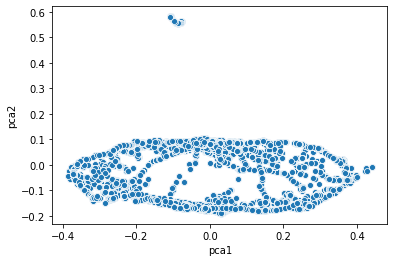

In [14]:
# PCA transformation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

coord = train[['latitude', 'longitude']] # 위도 경도 coord에 저장
pca = PCA(n_components=2)
pca.fit(coord)

coord_pca = pca.transform(coord)
coord_pca
train['pca1'] = coord_pca[:, 0]
train['pca2'] = coord_pca[:, 1]

sns.scatterplot(x='pca1', y='pca2', data=train)

In [15]:
coord_test = test[['latitude', 'longitude']] # 위도 경도 coord에 저장
pca = PCA(n_components=2)
pca.fit(coord_test)

coord_pca = pca.transform(coord_test)
coord_pca
test['pca1'] = coord_pca[:, 0]
test['pca2'] = coord_pca[:, 1]

## 6. bts정보

In [ ]:
# bus_route_id 별 정차 순서를 구하도록 함
bus_route_sequence = {}

combined = train.append(test, ignore_index=True)
all_bus_route_ids = set(combined['bus_route_id'])

for bus_route_id in tqdm_notebook( all_bus_route_ids ) :
    # bus_route_id별 station_code를 오름차순으로 순서매김함
    df_bus_route = combined[combined['bus_route_id']==bus_route_id]
    sorted_station_codes = np.unique(df_bus_route['station_code'])
    
    # dictionary에 해당 정류장이 몇번째 정차 정류장인지 기입
    bus_route_sequence[bus_route_id] = {station_code: ind for ind, station_code in enumerate( list(sorted_station_codes) )}

# 몇 번째 정류장인지를 피쳐로 생성
train['nth_station']= train[['bus_route_id','station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)
test['nth_station'] = test[['bus_route_id','station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)

# 해당 bus_route_id에는 몇 개의 정류장이 있는지
bus_route_id_total_station_count_dict = combined.groupby('bus_route_id')['station_code'].nunique().to_dict()

train['bus_route_id_total_staion_count'] = train['bus_route_id'].apply(lambda x: bus_route_id_total_station_count_dict.get(x) )
test['bus_route_id_total_staion_count']  = test['bus_route_id'].apply(lambda x: bus_route_id_total_station_count_dict.get(x) )

# 뒤에서부터 몇 번째 정류장인지
train['nth_station_backward']= train['nth_station'] - train['bus_route_id_total_staion_count']
test['nth_station_backward'] = test['nth_station'] - test['bus_route_id_total_staion_count']

## 7. 정류장 k-means

In [ ]:
# 중복되지 않는 위경도 값들을 수집함
combined = train[['latitude','longitude']].append(test[['latitude','longitude']])
combined = combined.drop_duplicates() 

# kmeans를 통하여 군집화
kmeans = KMeans(n_clusters= int(sqrt(len(combined)) ), random_state=1993)
kmeans.fit( combined )

train['station_code_kmeans'] = kmeans.predict(train[['latitude','longitude']])
test['station_code_kmeans']  = kmeans.predict(test[['latitude','longitude']])

In [ ]:
train['station_code_kmeans'].unique()

In [ ]:
fig = plt.figure(figsize=(16, 12))
fig = plt.subplot(221)
sns.scatterplot(x=train['longitude'], y=train['latitude'], hue = train['station_code_kmeans'])

In [ ]:
# 군집별 승차량 평균
train['cluster_target_mean'] = train.groupby(['station_code_kmeans'])['18~20_ride'].transform('mean') 
train['cluster_dawn_ride'] = train.groupby(['date','station_code_kmeans'])['dawn_ride'].transform('mean') 
train['cluster_morning_ride'] = train.groupby(['date','station_code_kmeans'])['morning_ride'].transform('mean') 
train['cluster_noon_ride'] = train.groupby(['date','station_code_kmeans'])['noon_ride'].transform('mean') 

test['cluster_target_mean'] = test.groupby(['station_code_kmeans'])['18~20_ride'].transform('mean') 
test['cluster_dawn_ride'] = test.groupby(['date','station_code_kmeans'])['dawn_ride'].transform('mean') 
test['cluster_morning_ride'] = test.groupby(['date','station_code_kmeans'])['morning_ride'].transform('mean') 
test['cluster_noon_ride'] = test.groupby(['date','station_code_kmeans'])['noon_ride'].transform('mean') 

In [ ]:
train.columns

## 8. 그 외 피쳐


In [ ]:
## 혼잡도
# 1. 버스 노선 id에 따른 혼잡도(Congestion)
def congestion() :
    df = train.groupby(['bus_route_id'])['18~20_ride'].agg([('passenger', 'sum')])
    df = df.sort_values(by='passenger', ascending=False).reset_index()
    
    def f(x):
        if x > 10000:
            return 7

        elif x > 5000:
            return 6

        elif x > 2000:
            return 5

        elif x > 700:
            return 4

        elif x > 200:
            return 3

        elif x > 50:
            return 2

        else:
            return 1
    
    df['congestion']=df['passenger'].apply(f)
    df = df[['bus_route_id','congestion']]
    
    tr = pd.merge(train, df, how='left', on='bus_route_id')
    te = pd.merge(test, df, how='left', on='bus_route_id')
    
    # 결측치는 데이터 프레임 df의 'congestion'의 중간값인 '4'으로 대체
    te = te.fillna(4)
    
    return tr, te
train, test = congestion()

# 2. station code에 따른 혼잡도
df = train.groupby(['station_code'])['18~20_ride'].agg([('passenger', 'sum')])
df = df.sort_values(by='passenger', ascending=False).reset_index() # station_code에 따른 승객 수

def f(x):
  if x>250:
    return 6

  elif x>150:
    return 5

  elif x>70:
    return 4

  elif x>40:
    return 3

  elif x>5:
    return 2

  else:
    return 1

df['s_congestion'] = df['passenger'].apply(f)
df = df[['station_code', 's_congestion']]

train = pd.merge(train, df, how='left', on='station_code')
test = pd.merge(test, df, how='left', on='station_code')
test = test.fillna(4)

## 9. 외부데이터 추가

In [ ]:
# 항공 데이터(근데 당일마다 18시 이전의 통계량만 읽어와야 함. 리키지 유의하자!)
# pandas로 html 파일 불러오기
month = 8
day = 29
df = pd.read_html('https://www.airport.co.kr/www/extra/dailyExpect/dailyExpectList/layOut.do?yyyy=2019&mm='+str(month) +'&dd=' + str(day))
df = df[1]
df = df.iloc[:54] # leakage 방지
df.tail()

In [ ]:
df.columns = ['시간대','','','','','', '제주_국내','제주_국제','','','','', '', '', '', '']
df = df[['제주_국내','제주_국제']]

In [ ]:
# 항공 데이터(근데 당일마다 18시 이전의 통계량만 읽어와야 함. 리키지 유의하자!)
# pandas로 html 파일 불러오기
from tqdm import tqdm_notebook
date = []
국내_list = []
국제_list = []

for month in tqdm_notebook( [9, 10]):
  if month == 9:
    for day in tqdm_notebook( range(1,31)):
      df = pd.read_html('https://www.airport.co.kr/www/extra/dailyExpect/dailyExpectList/layOut.do?yyyy=2019&mm='+str(month) +'&dd=' + str(day))[1]
      df = df.iloc[:54] # 리키지 방지
      df.columns = ['시간대','','','','','', '제주_국내','제주_국제','','','','', '', '', '', '']
      df = df[['제주_국내','제주_국제']]
      국내, 국제 = df.sum(axis=0).values
      date.append( '2019-' + '09-' + str(day) )
      국내_list.append(국내)
      국제_list.append(국제)

  if month == 10:
    for day in tqdm_notebook( range(1,17)):
      df = pd.read_html('https://www.airport.co.kr/www/extra/dailyExpect/dailyExpectList/layOut.do?yyyy=2019&mm='+str(month) +'&dd=' + str(day))[1]
      df = df.iloc[:54] # 리키지 방지
      df.columns = ['시간대','','','','','', '제주_국내','제주_국제','','','','', '', '', '', '']
      df = df[['제주_국내','제주_국제']]
      국내, 국제 = df.sum(axis=0).values
      date.append( '2019-' + '10-' + str(day) )
      국내_list.append(국내)
      국제_list.append(국제)

In [ ]:
airport = pd.DataFrame(data = {'date':date, '국내관광객':국내_list, '국제관광객':국제_list})
# airport.to_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/airport910.csv', index=False)
airport['date'] = pd.to_datetime(airport['date'])
airport = airport.rename(columns={'국내관광객':'in_tourist', '국제관광객':'out_tourist'})

In [ ]:
airport.head()

In [ ]:
train['is_test'] = 0
test['is_test'] = 1
data = pd.concat([train, test])
data = pd.merge(data, airport, how = 'left', on = 'date')
train = data.query('is_test==0')
test = data.query('is_test==1')

In [ ]:
train.to_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/best_train.csv', index=False)
test.to_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/best_test.csv', index=False)

## < Modeling >
- lgbm
- xgboost
- random forest
- tpot
- catboost
> permutation 

In [ ]:
# 1. lgbm + fold 5 
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,
              'learning_rate':0.01,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.68,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

target_col = '18~20_ride'
drop_cols = ['date','id',target_col]
train_label = train[target_col]

test[target_col] = np.NaN

# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))
lgbm_oof_test = np.zeros((test.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    test['station_code_te'] = test['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       categorical_feature= ['bus_route_id','station_code', 'station_code_kmeans'],
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    lgbm_test_pred = model.predict(test.drop(drop_cols, 1))
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/ n_splits
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] =lgbm_oof_test.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/lgbm0816.csv", index=False)

In [ ]:
## 2. random forest
X = train.drop(['id', 'date', 'is_test', '18~20_ride', 'bus_route_id','station_code','station_name'], axis=1)
y = train['18~20_ride']
X_test = test.drop(['id', 'date', 'is_test', 'bus_route_id','station_code','station_name', '18~20_ride'], axis=1)
X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [ ]:
print(X.shape, y.shape, X_test.shape)

In [ ]:
X_test.columns.difference(X.columns)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=2020, test_size=0.1)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_features=3,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=500,
                           random_state=1217)

rf.fit(X_train,y_train) 
rf_pred = rf.predict(X_test) 
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] = rf_pred.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/rf_only0816.csv", index=False)

In [ ]:
# 3. xgb(20시간)
%%time
import xgboost as xgb

dtrain = xgb.DMatrix(X, y)
dtest = xgb.DMatrix(X_test)

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
    # 'alpha': 0.05
    # 'lambda': 0.05
    }

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=50000, 
                   early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] = preds.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/0817xgboost.csv", index=False)

[0]	train-rmse:4.75311	test-rmse:4.755
[500]	train-rmse:2.30026	test-rmse:2.66593
[1000]	train-rmse:2.10195	test-rmse:2.56353
[1500]	train-rmse:1.97849	test-rmse:2.50932
[2000]	train-rmse:1.88127	test-rmse:2.47107
[2500]	train-rmse:1.80115	test-rmse:2.44386
[3000]	train-rmse:1.73186	test-rmse:2.42238
[3500]	train-rmse:1.6723	test-rmse:2.40575
[4000]	train-rmse:1.62027	test-rmse:2.39177
[4500]	train-rmse:1.57271	test-rmse:2.38012
[5000]	train-rmse:1.52933	test-rmse:2.37048
[5500]	train-rmse:1.49069	test-rmse:2.36209
[6000]	train-rmse:1.45522	test-rmse:2.35501
[6500]	train-rmse:1.42288	test-rmse:2.34894
[7000]	train-rmse:1.39317	test-rmse:2.34363
[7500]	train-rmse:1.36526	test-rmse:2.33914
[8000]	train-rmse:1.33905	test-rmse:2.33496
[8500]	train-rmse:1.3145	test-rmse:2.33167
[9000]	train-rmse:1.29107	test-rmse:2.32827
[9500]	train-rmse:1.26912	test-rmse:2.32561
[10000]	train-rmse:1.24805	test-rmse:2.32301
[10500]	train-rmse:1.22818	test-rmse:2.32062
[11000]	train-rmse:1.20931	test-rmse:2

In [ ]:
# 4. Permutation
%%time
from sklearn.inspection import permutation_importance
r = permutation_importance(rf, X_val, y_val, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2*r.importances_std[i]>0:
    print(f"{X_train.feature_names[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

In [ ]:
# 5. catboosting
# 각 모델에 대한 oof 정의
n_splits= 5
SEED = 1993

target_col = '18~20_ride'
drop_cols = ['date','id',target_col]
train_label = train[target_col]

from catboost import CatBoostRegressor

cat_oof_train = np.zeros((train.shape[0]))
cat_oof_test = np.zeros((test.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    test['station_code_te'] = test['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) CATBOOST
    print("---TRAINING CATBOOST---")
    
    # model 정의&학습
    n_rounds = 100000
    n_splits = 5

    cat_params = {
          'n_estimators': n_rounds,
          'learning_rate': 0.05,
          'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
          'random_seed': 42,
          'metric_period': 500,
          'od_wait': 500,
          'task_type': 'GPU',
          'l2_leaf_reg' : 3,
          'depth': 8 }

    model = CatBoostRegressor(n_estimators= 100000, learning_rate=0.05, eval_metric='RMSE', loss_function= 'RMSE')
    
    model.fit( X_train, y_train, eval_set = (X_valid, y_valid))


    # model.fit( X_train, y_train, eval_set = (X_valid, y_valid)) 

    
    # local_valid/local_test에 대한 예측
    cat_valid_pred = model.predict(X_valid)
    cat_test_pred = model.predict(test.drop(drop_cols, 1))
        
    cat_oof_train[val_ind] = cat_valid_pred
    cat_oof_test += cat_test_pred/ n_splits
    print('='*80)
    
print(f"<CATBOOST> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, cat_oof_train ) )}")

In [ ]:
# 6. Tpot
!pip install tpot
from tpot import TPOTRegressor

X = train.drop(['id', 'date', 'is_test', '18~20_ride', 'bus_route_id','station_code','station_name'], axis=1)
y = train['18~20_ride']
X_test = test.drop(['id', 'date', 'is_test', 'bus_route_id','station_code','station_name', '18~20_ride', 'station_code_te'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
tpot = TPOTRegressor(generations=25, population_size=25, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

## < Ensemble >
- submission voting
- Power mean

In [ ]:
## voting(2등커널 활용)
# Ensemble 1
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
ensemble_pred = 0.5 * ( lgbm_oof_test+ s_pred )
sample_submission[target_col] = np.clip( ensemble_pred, 0 , max(ensemble_pred) )
sample_submission.to_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/lgbm_2_ensemble.csv', index=False)

# Ensemble 2
s = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/lgb2nd.csv')
s_pred = np.array(s['18~20_ride'].tolist())
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
ensemble_pred =  0.2*lgbm_oof_test+ 0.8*s_pred 
sample_submission[target_col] = np.clip( ensemble_pred, 0 , max(ensemble_pred) )
sample_submission.to_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/lgbm_37_ensemble0816.csv', index=False)

# Ensemble 3
xgb = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/0813xgboost.csv')
xgb_pred = np.array(xgb['18~20_ride'].tolist())
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
ensemble_pred =  0.1*lgbm_oof_test+ 0.1*xgb_pred+ 0.8*s_pred 
sample_submission[target_col] = np.clip( ensemble_pred, 0 , max(ensemble_pred) )
sample_submission.to_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/lgbm_xgb_118_ensemble0816.csv', index=False)

In [ ]:
# Power Mean
import pandas as pd
import numpy as np
import os

folder = 'C:/Users/이다은/Desktop/BOAZ 14기/데이콘 프로젝트^ㅁ^/버스 승차량 예측/ensemble'

nf = 0
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="id")
    nf += 1

# 최적의 p값 = -139
p = -139
if nf >= 2:
    pred = 0
    for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
    pred = pred / nf    
    pred = pred**(1/p)

    submit = pd.DataFrame({'id': slist.id, '18~20_ride': pred})
    t = pd.Timestamp.now()
    fname = "2번째0.5.csv"
    submit.to_csv(fname, index=False)
    
    print(fname)

최고성능 : 2.0518532656	(RMSE)